In [95]:
# Install PyTorch Lightning if not installed
!pip install pytorch-lightning torchvision torchmetrics

# Download Imagenette dataset
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xvzf imagenette2-160.tgz


Streaming output truncated to the last 5000 lines.
imagenette2-160/train/n03888257/n03888257_16077.JPEG
imagenette2-160/train/n03888257/n03888257_23339.JPEG
imagenette2-160/train/n03888257/n03888257_44204.JPEG
imagenette2-160/train/n03888257/n03888257_61633.JPEG
imagenette2-160/train/n03888257/n03888257_15067.JPEG
imagenette2-160/train/n03888257/n03888257_75365.JPEG
imagenette2-160/train/n03888257/n03888257_63966.JPEG
imagenette2-160/train/n03888257/n03888257_3927.JPEG
imagenette2-160/train/n03888257/n03888257_20684.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-160/train/n03888257/n03888257_14016.JPEG
imagenette2-160/train/n03888257/n03888257_37776.JPEG
imagenette2-160/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-160/train/n03888257/n03888257_17513.JPEG
imagenette2-160/train/n03888257/n03888257_17143.JPEG
imagenette2-160/train/n03888257/n03888257_6738.JPEG
imagenette2-160/train/n03888257/n03888257_4355.JPEG
imagenette2-160/train/n03888257/ILS

In [96]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torchvision
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint


# A Basic CNN

The model is a basic CNN composed of 3 convolutional layers with increasing filter sizes (16, 32, 64). Each convolution is followed by ReLU activation, Batch Normalization, and MaxPooling. After flattening, the network has two fully connected layers: one with 128 units and ReLU, and a final output layer with units equal to the number of classes.

In [97]:
# Reproducibility
pl.seed_everything(42)

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load and split dataset
dataset_path = "imagenette2-160"
full_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=transform_train)

num_samples = len(full_dataset)
indices = torch.randperm(num_samples)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [98]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Dataset
dataset_path = "imagenette2-160"
full_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=transform_train)
num_classes = len(full_dataset.classes)

# Split
n = len(full_dataset)
train_len = int(0.8 * n)
val_len = int(0.1 * n)
test_len = n - train_len - val_len
train_set, val_set, test_set = torch.utils.data.random_split(full_dataset, [train_len, val_len, test_len])
val_set.dataset.transform = transform_test
test_set.dataset.transform = transform_test

# Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)


In [99]:
cnn_train_losses = []
cnn_val_losses = []


In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy

# Globals to store metrics
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []

class BasicCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.save_hyperparameters()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.feature_dim = 64 * 8 * 8

        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_dim, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        cnn_train_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        cnn_train_accuracies.append(self.train_acc.compute().item())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        cnn_val_losses.append(loss.item())

    def on_validation_epoch_end(self):
        cnn_val_accuracies.append(self.val_acc.compute().item())
        self.val_acc.reset()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


In [101]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=3,
    mode="min",
    verbose=True
)


In [102]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torchvision
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [103]:
model = BasicCNN(num_classes=len(full_dataset.classes))
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 23.8 K | train
1 | flatten     | Flatten            | 0      | train
2 | fc_layers   | Sequential         | 525 K  | train
3 | loss_fn     | CrossEntropyLoss   | 0      | train
4 | train_acc   | MulticlassAccuracy | 0      | train
5 | val_acc     | MulticlassAccuracy | 0      | train
----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 1.093


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.291 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.316 >= min_delta = 0.0. New best score: 0.486


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.486. Signaling Trainer to stop.


In [104]:
import numpy as np
batches_per_epoch = len(train_loader)

# Compute average train loss per epoch
avg_train_losses_cnn = [
    np.mean(cnn_train_losses[i:i + batches_per_epoch])
    for i in range(0, len(cnn_train_losses), batches_per_epoch)
]

# Validation losses already contain one per epoch
avg_val_losses_cnn = cnn_val_losses[:len(avg_train_losses_cnn)]


In [105]:
# Create the table
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Epoch", "Train Loss", "Validation Loss"]

for i, (train_loss, val_loss) in enumerate(zip(avg_train_losses_cnn, avg_val_losses_cnn), start=1):
    table.add_row([i, f"{train_loss:.4f}", f"{val_loss:.4f}"])

# Print the table
print("BasicCNN: Training and Validation Loss per Epoch\n")
print(table)


BasicCNN: Training and Validation Loss per Epoch

+-------+------------+-----------------+
| Epoch | Train Loss | Validation Loss |
+-------+------------+-----------------+
|   1   |   1.6175   |      2.3082     |
|   2   |   1.1604   |      2.3160     |
|   3   |   0.9464   |      1.1413     |
|   4   |   0.7646   |      1.2355     |
|   5   |   0.6071   |      1.1684     |
|   6   |   0.4540   |      1.3691     |
+-------+------------+-----------------+


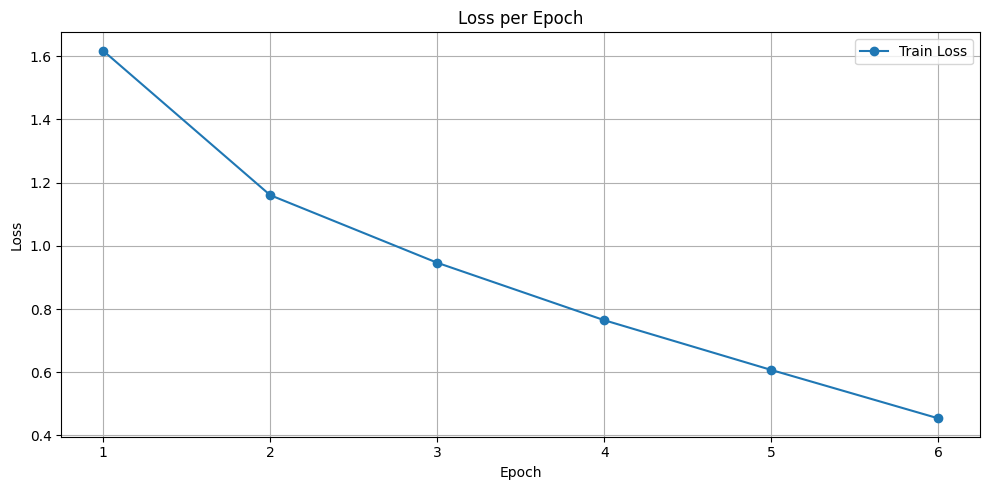

In [106]:
import numpy as np
import matplotlib.pyplot as plt

batches_per_epoch = len(train_loader)

avg_train_losses = [
    np.mean(cnn_train_losses[i:i+batches_per_epoch])
    for i in range(0, len(cnn_train_losses), batches_per_epoch)
]

avg_val_losses = cnn_val_losses[:len(avg_train_losses)]
epochs = range(1, len(avg_train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_losses, label="Train Loss", marker="o")
#plt.plot(epochs, avg_val_losses, label="Val Loss", marker="s")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


In [107]:
# Put model in evaluation mode
model.eval()

# Accuracy metric for test
test_acc = Accuracy(task="multiclass", num_classes=len(full_dataset.classes)).to(model.device)

# No gradients needed during evaluation
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(model.device), y.to(model.device)
        y_hat = model(x)
        test_acc.update(y_hat, y)

# Compute and print final accuracy
final_accuracy = test_acc.compute().item()
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Final Test Accuracy: 0.6698


# ResNet 18



In this part, I used the ResNet18 architecture. The model was initialized with pretrained weights (Imagenet) and then adapted for our custom classification task by replacing the final fully connected (FC) layer to match the number of classes in the dataset.
To prevent overfitting, early stopping was implemented based on the training loss, which halts training if no improvement is seen over a set number of epochs.

In [108]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights


In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.classification import Accuracy

class ResNet18Classifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.save_hyperparameters()

        # Load pretrained ResNet18
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Replace the final classification layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Loss and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # Track losses for plotting
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append(loss.item())

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return {"test_loss": loss, "test_acc": acc}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=2, factor=0.5, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


In [110]:
# resnet_model = ResNet18Classifier(num_classes=len(full_dataset.classes))


early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=3,
    mode="min",
    verbose=True,
    check_on_train_epoch_end=True
)

resnet_model = ResNet18Classifier(num_classes=num_classes)

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_callback]
)

trainer.fit(resnet_model, train_loader, val_loader)
trainer.test(resnet_model, dataloaders=test_loader)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.693


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.555 >= min_delta = 0.0. New best score: 0.138


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.100


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.068


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.002. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8702531456947327     │
│         test_loss         │    0.5040605068206787     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5040605068206787, 'test_acc': 0.8702531456947327}]

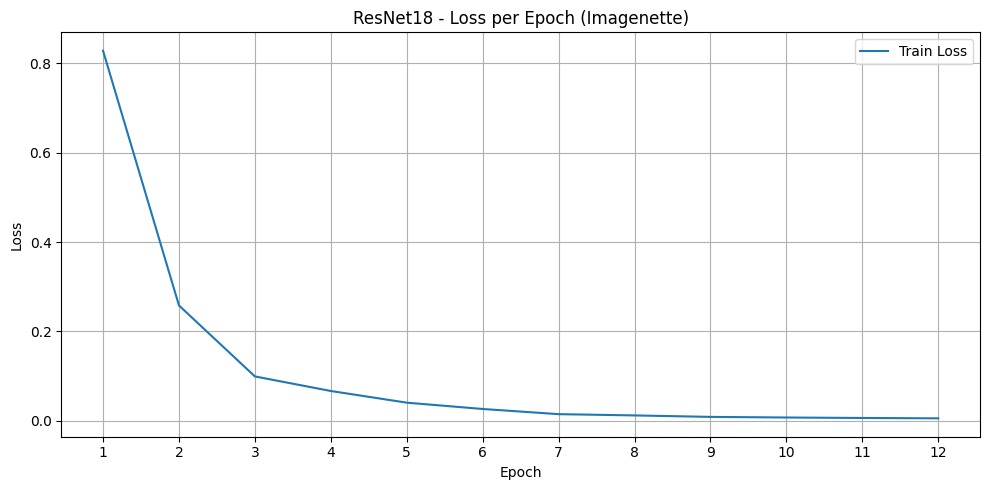

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# One val loss per epoch
# Average train loss per epoch
batches_per_epoch = len(train_loader)
avg_train_loss_resnet = [
    np.mean(resnet_model.train_losses[i:i + batches_per_epoch])
    for i in range(0, len(resnet_model.train_losses), batches_per_epoch)
]

# Match val losses to length of avg train losses
avg_val_loss_resnet = resnet_model.val_losses[:len(avg_train_loss_resnet)]
epochs = range(1, len(avg_train_loss_resnet) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss_resnet, label="Train Loss")
#plt.plot(epochs, avg_val_loss_resnet, label="Val Loss", marker='s')
plt.title("ResNet18 - Loss per Epoch (Imagenette)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


In [112]:
# Put model in evaluation mode
model.eval()

# Accuracy metric for test
test_acc = Accuracy(task="multiclass", num_classes=len(full_dataset.classes)).to(resnet_model.device)

# No gradients needed during evaluation
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(resnet_model.device), y.to(resnet_model.device)
        y_hat = resnet_model(x)
        test_acc.update(y_hat, y)

# Compute and print final accuracy
final_accuracy = test_acc.compute().item()
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Final Test Accuracy: 0.8608


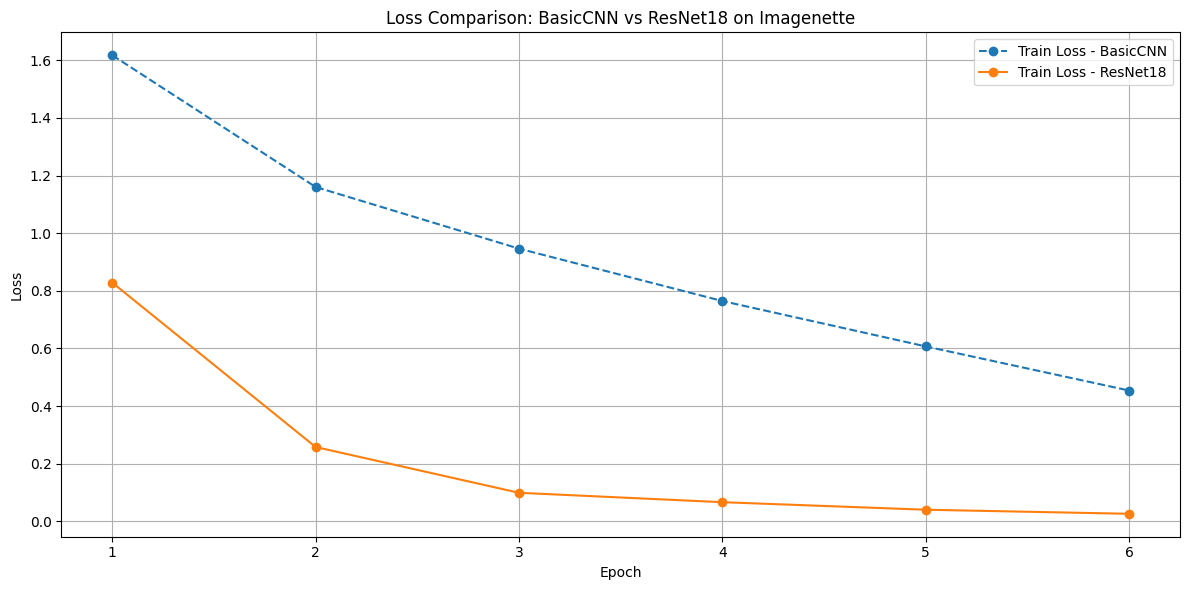

In [113]:
import matplotlib.pyplot as plt

# Ensure same number of epochs for fair comparison
min_len = min(
    len(avg_train_losses_cnn),
    len(avg_val_losses_cnn),
    len(avg_train_loss_resnet),
    len(avg_val_loss_resnet)
)
epochs = range(1, min_len + 1)

# Trim to equal length
cnn_train = avg_train_losses_cnn[:min_len]
cnn_val = avg_val_losses_cnn[:min_len]
resnet_train = avg_train_loss_resnet[:min_len]
resnet_val = avg_val_loss_resnet[:min_len]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, cnn_train, label="Train Loss - BasicCNN", linestyle="--", marker="o")
#plt.plot(epochs, cnn_val, label="Val Loss - BasicCNN", linestyle="--", marker="s")
plt.plot(epochs, resnet_train, label="Train Loss - ResNet18", linestyle="-", marker="o")
#plt.plot(epochs, resnet_val, label="Val Loss - ResNet18", linestyle="-", marker="s")

plt.title("Loss Comparison: BasicCNN vs ResNet18 on Imagenette")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()


# Comparison of BasicCNN vs ResNet18
## The plot compares training loss across epochs for both BasicCNN and ResNet18 models.

- ResNet18 converges faster and generalizes better.


# Regularization

## Regularization in the form of data augmentation

In this section, I applied regularization through data augmentation to the ResNet18 model previously used in Part 2. The augmentations included RandomCrop, RandomHorizontalFlip, and normalization. These transformations were applied to the training set using PyTorch’s transforms.Compose, and the model was then re-trained using the same architecture.

In [114]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


In [115]:
full_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'), transform=transform_train
)

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test


In [116]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=3,
    mode="min",
    verbose=True,
    check_on_train_epoch_end=True
)


In [117]:
resnet_aug = ResNet18Classifier(num_classes=len(full_dataset.classes))

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_callback]
)

trainer.fit(resnet_aug, train_loader, val_loader)
trainer.test(resnet_aug, dataloaders=test_loader)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.607


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.489 >= min_delta = 0.0. New best score: 0.118


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.027


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8723628520965576     │
│         test_loss         │    0.4981703758239746     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4981703758239746, 'test_acc': 0.8723628520965576}]

In [118]:
# Save only weights
torch.save(resnet_aug.state_dict(), "model_reg_weights.pth")
# Save the trained model weights after training on Imagenette
torch.save(resnet_aug.state_dict(), "resnet_aug_weights.pth")
print("Saved Imagenette-trained weights!")


Saved Imagenette-trained weights!


In [119]:
!pip install prettytable
from prettytable import PrettyTable
import numpy as np


In [120]:
batches_per_epoch = len(train_loader)

# Calculate average training loss per epoch
avg_train_loss_resnet = [
    np.mean(resnet_model.train_losses[i:i + batches_per_epoch])
    for i in range(0, len(resnet_model.train_losses), batches_per_epoch)
]

# Match number of validation epochs
avg_val_loss_resnet = resnet_model.val_losses[:len(avg_train_loss_resnet)]


In [121]:
# Create table
table = PrettyTable()
table.field_names = ["Epoch", "Train Loss", "Validation Loss"]

for i, (t_loss, v_loss) in enumerate(zip(avg_train_loss_resnet, avg_val_loss_resnet), start=1):
    table.add_row([i, f"{t_loss:.4f}", f"{v_loss:.4f}"])

# Display table
print("Training and Validation Loss per Epoch:\n")
print(table)


Training and Validation Loss per Epoch:

+-------+------------+-----------------+
| Epoch | Train Loss | Validation Loss |
+-------+------------+-----------------+
|   1   |   0.8285   |      3.1886     |
|   2   |   0.2581   |      2.8294     |
|   3   |   0.0992   |      0.6356     |
|   4   |   0.0666   |      0.4010     |
|   5   |   0.0404   |      0.9679     |
|   6   |   0.0263   |      0.4741     |
|   7   |   0.0147   |      0.4032     |
|   8   |   0.0119   |      0.6884     |
|   9   |   0.0086   |      0.6841     |
|   10  |   0.0072   |      0.6762     |
|   11  |   0.0062   |      0.1335     |
|   12  |   0.0053   |      0.4420     |
+-------+------------+-----------------+


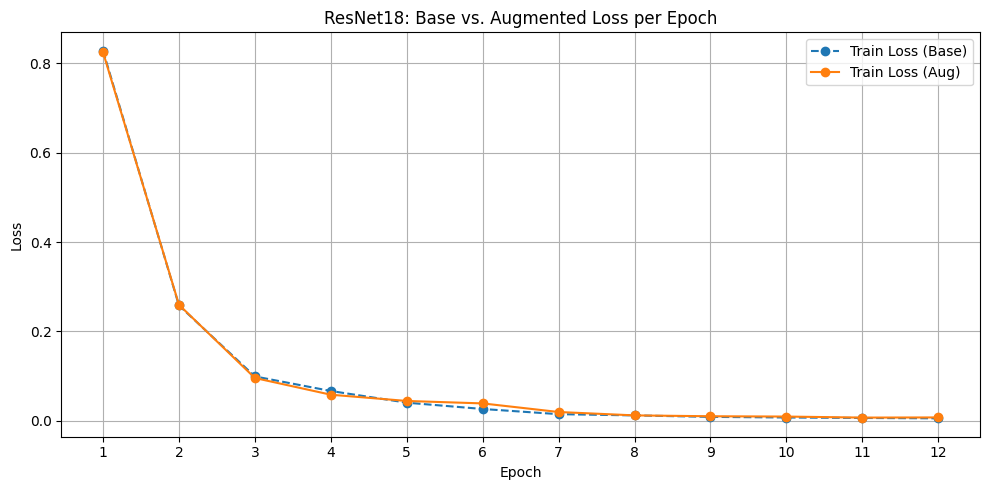

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average losses for augmentation model
batches_per_epoch = len(train_loader)

avg_train_loss_aug = [
    np.mean(resnet_aug.train_losses[i:i+batches_per_epoch])
    for i in range(0, len(resnet_aug.train_losses), batches_per_epoch)
]
avg_val_loss_aug = resnet_aug.val_losses[:len(avg_train_loss_aug)]

# Calculate average losses for base model
avg_train_loss_resnet = [
    np.mean(resnet_model.train_losses[i:i+batches_per_epoch])
    for i in range(0, len(resnet_model.train_losses), batches_per_epoch)
]
avg_val_loss_resnet = resnet_model.val_losses[:len(avg_train_loss_resnet)]

# Make sure all plotted arrays have the same length
min_len = min(
    len(avg_train_loss_resnet),
    len(avg_val_loss_resnet),
    len(avg_train_loss_aug),
    len(avg_val_loss_aug)
)
epochs = range(1, min_len + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss_resnet[:min_len], label="Train Loss (Base)", linestyle='--', marker='o')
#plt.plot(epochs, avg_val_loss_resnet[:min_len], label="Val Loss (Base)", linestyle='--', marker='s')
plt.plot(epochs, avg_train_loss_aug[:min_len], label="Train Loss (Aug)", marker='o')
#plt.plot(epochs, avg_val_loss_aug[:min_len], label="Val Loss (Aug)", marker='s')

plt.title("ResNet18: Base vs. Augmented Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()


In [123]:
# Import metric
from torchmetrics.classification import Accuracy
from torch.utils.data import DataLoader

# Setup test accuracy metric
test_acc_aug = Accuracy(task="multiclass", num_classes=len(full_dataset.classes)).to(resnet_aug.device)

# Set model to eval mode
resnet_aug.eval()

# Compute test accuracy
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(resnet_aug.device), y.to(resnet_aug.device)
        y_hat = resnet_aug(x)
        test_acc_aug.update(y_hat, y)

# Final accuracy value
final_test_acc_aug = test_acc_aug.compute().item()
print(f"Final Test Accuracy (Augmented ResNet18): {final_test_acc_aug:.4f}")


Final Test Accuracy (Augmented ResNet18): 0.8724


In [124]:
# Create table
table = PrettyTable()
table.field_names = ["Epoch", "Train Loss", "Train Loss Augmented"]

for i, (t_loss, v_loss) in enumerate(zip(avg_train_loss_resnet, avg_train_loss_aug), start=1):
    table.add_row([i, f"{t_loss:.4f}", f"{v_loss:.4f}"])

# Display table
print("Training and Validation Loss per Epoch:\n")
print(table)

Training and Validation Loss per Epoch:

+-------+------------+----------------------+
| Epoch | Train Loss | Train Loss Augmented |
+-------+------------+----------------------+
|   1   |   0.8285   |        0.8252        |
|   2   |   0.2581   |        0.2596        |
|   3   |   0.0992   |        0.0956        |
|   4   |   0.0666   |        0.0583        |
|   5   |   0.0404   |        0.0442        |
|   6   |   0.0263   |        0.0388        |
|   7   |   0.0147   |        0.0195        |
|   8   |   0.0119   |        0.0120        |
|   9   |   0.0086   |        0.0100        |
|   10  |   0.0072   |        0.0093        |
|   11  |   0.0062   |        0.0070        |
|   12  |   0.0053   |        0.0074        |
+-------+------------+----------------------+


# Transfer Learning from Imagenette to CIFAR-10

## Using a model from a previous run, re-train it from scratch on the CIFAR10 dataset.

For transfer learning, I used the ResNet18 model that I had already trained on the Imagenette dataset. I saved the weights after training and then loaded them into a new ResNet18 model.
To use it for CIFAR-10, I changed the final layer of the model to output 10 classes. I then fine-tuned the model on the CIFAR-10 dataset, allowing all layers to update during training.


In [125]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [126]:
# Transforms (resize to match Imagenette size)
cifar_transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
cifar_transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# CIFAR-10 Load
cifar_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_transform_train)
cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_transform_test)

# Split train into train and val
train_len = int(0.9 * len(cifar_train))
val_len = len(cifar_train) - train_len
cifar_train, cifar_val = random_split(cifar_train, [train_len, val_len])
cifar_val.dataset.transform = cifar_transform_test

# Dataloaders
train_loader_cifar = DataLoader(cifar_train, batch_size=32, shuffle=True, num_workers=2)
val_loader_cifar = DataLoader(cifar_val, batch_size=32, shuffle=False, num_workers=2)
test_loader_cifar = DataLoader(cifar_test, batch_size=32, shuffle=False, num_workers=2)


In [127]:
# from pytorch_lightning.callbacks import ModelCheckpoint

# # Save the best model
# checkpoint_callback = ModelCheckpoint(
#     monitor="train_loss",          # What to monitor
#     mode="min",                  # Lower val_loss is better
#     save_top_k=1,                # Save only the best model
#     dirpath="checkpoints",       # Folder to save to
#     filename="best-transfer-model"  # Name of the saved file
# )


In [128]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torchvision.models import resnet18
import torch.nn as nn

# Create model with SAME architecture used
resnet_reg = ResNet18Classifier(num_classes=10)  # output layer adjusted for CIFAR-10

resnet_aug = ResNet18Classifier(num_classes=10)  # 10 classes for CIFAR10
resnet_aug.load_state_dict(torch.load("resnet_aug_weights.pth"))  #


# Replace head to match CIFAR-10 classes
resnet_reg.model.fc = nn.Linear(resnet_reg.model.fc.in_features, 10)


for param in resnet_reg.model.parameters():
    param.requires_grad = True

# Trainer with early stopping
early_stop_cifar = EarlyStopping(monitor="train_loss", patience=3, mode="min", verbose=True)

trainer_cifar = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_cifar]
)

# Fine-tune on CIFAR-10
trainer_cifar.fit(resnet_reg, train_loader_cifar, val_loader_cifar)

# Evaluate on CIFAR-10 test set
trainer_cifar.test(resnet_reg, dataloaders=test_loader_cifar)



INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.656


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.634 >= min_delta = 0.0. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.003. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9115999937057495     │
│         test_loss         │     0.381134569644928     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.381134569644928, 'test_acc': 0.9115999937057495}]

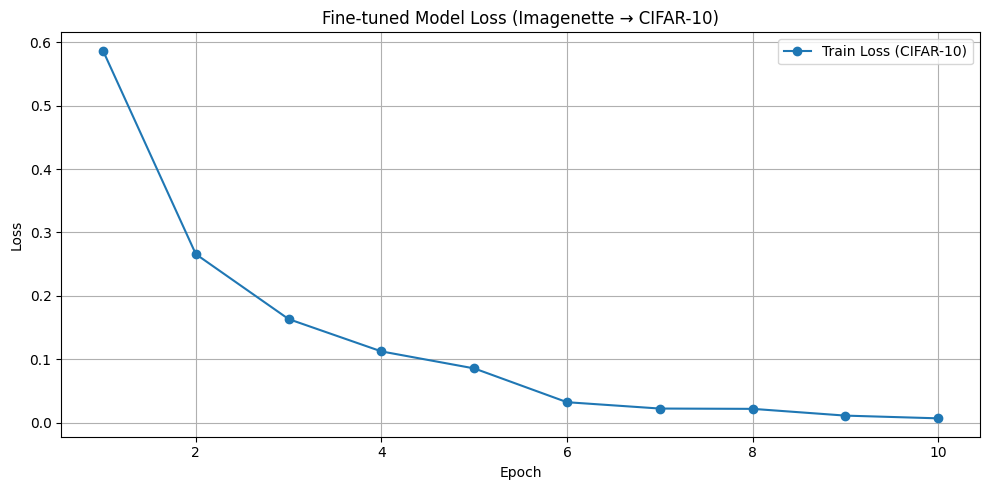

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Number of batches in one epoch
batches_per_epoch = len(train_loader_cifar)

# Get average loss per epoch
avg_train_loss = [
    np.mean(resnet_reg.train_losses[i : i + batches_per_epoch])
    for i in range(0, len(resnet_reg.train_losses), batches_per_epoch)
]
avg_val_loss = resnet_reg.val_losses[:len(avg_train_loss)]
epochs = range(1, len(avg_train_loss) + 1)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss, label="Train Loss (CIFAR-10)", marker="o")
#plt.plot(epochs, avg_val_loss, label="Val Loss (CIFAR-10)", marker="s")
plt.title("Fine-tuned Model Loss (Imagenette → CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
trainer_cifar.test(resnet_reg, dataloaders=test_loader_cifar)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9115999937057495     │
│         test_loss         │     0.381134569644928     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.381134569644928, 'test_acc': 0.9115999937057495}]

In [131]:
results = trainer_cifar.test(resnet_reg, dataloaders=test_loader_cifar)
test_accuracy = results[0]["test_acc"]
print(f"\nFinal Test Accuracy on CIFAR-10: {test_accuracy * 100:.2f}%")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9115999937057495     │
│         test_loss         │     0.381134569644928     │
└───────────────────────────┴───────────────────────────┘


Final Test Accuracy on CIFAR-10: 91.16%


## Using the same model and initialize it with pre-trained weights from the Imagenette dataset. With the pre-trained model, fine-tune it on the CIFAR10 dataset.

In [132]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torchvision.models import resnet18

# Define same model architecture used in Part 3
resnet_reg = ResNet18Classifier(num_classes=10)

# Load Imagenette weights saved in Part 3
resnet_reg.load_state_dict(torch.load("model_reg_weights.pth"))

# Replace classification head for CIFAR-10
resnet_reg.model.fc = torch.nn.Linear(resnet_reg.model.fc.in_features, 10)


for param in resnet_reg.model.parameters():
    param.requires_grad = True

# Setup early stopping
early_stop_cifar = EarlyStopping(
    monitor="train_loss",
    patience=3,
    mode="min",
    verbose=True
)

# Train
trainer_cifar = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    callbacks=[early_stop_cifar]
)
trainer_cifar.fit(resnet_reg, train_loader_cifar, val_loader_cifar)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.121. Signaling Trainer to stop.


In [133]:
test_results = trainer_cifar.test(resnet_reg, dataloaders=test_loader_cifar)
print(f"Final Test Accuracy on CIFAR-10: {test_results[0]['test_acc'] * 100:.2f}%")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8921999931335449     │
│         test_loss         │    0.37463292479515076    │
└───────────────────────────┴───────────────────────────┘

Final Test Accuracy on CIFAR-10: 89.22%


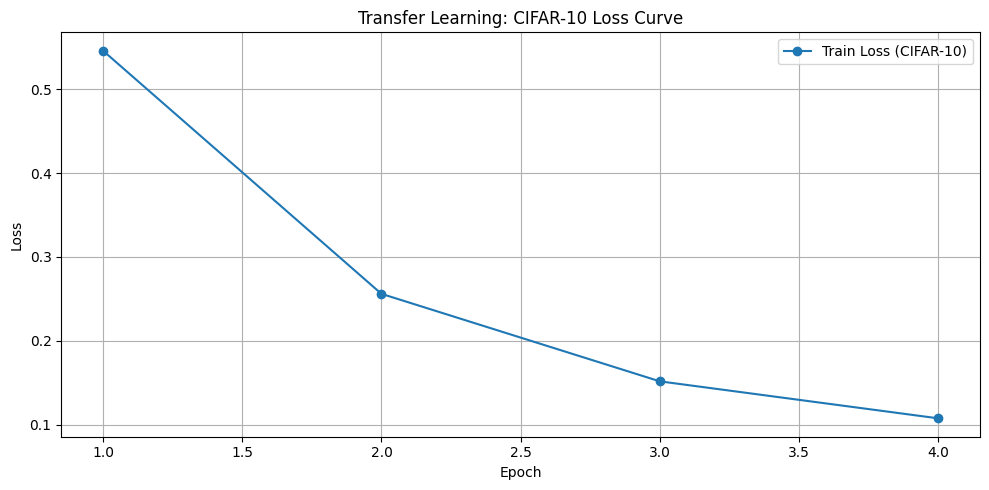

In [134]:
import matplotlib.pyplot as plt
import numpy as np

batches_per_epoch = len(train_loader_cifar)
val_batches_per_epoch = len(val_loader_cifar)
epochs = range(1, len(resnet_reg.train_losses) // batches_per_epoch + 1)

# Compute average loss per epoch
avg_train_loss = [
    np.mean(resnet_reg.train_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch])
    for i in range(len(epochs))
]

avg_val_loss = [
    np.mean(resnet_reg.val_losses[i * val_batches_per_epoch:(i + 1) * val_batches_per_epoch])
    for i in range(len(epochs))
]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss, label='Train Loss (CIFAR-10)', marker='o')
#plt.plot(epochs, avg_val_loss, label='Val Loss (CIFAR-10)', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transfer Learning: CIFAR-10 Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
